In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bdshare import get_basic_hist_data

In [2]:
start='2020-01-1'
end='2023-8-26'

In [3]:
stock_data=get_basic_hist_data(start,end,'UNIQUEHRL',index='date')

In [4]:
stock_data=stock_data.reset_index()

In [5]:
high,low,close='high','low','close'

In [6]:
columns=['date',high,low,close]
stock_data=stock_data[columns]
stock_data

,date,high,low,close
0,2021-08-26,45.7,44.5,44.6
1,2021-08-29,45.0,43.9,44.1
2,2021-08-31,45.5,43.9,44.6
3,2021-09-01,44.9,43.6,43.8
4,2021-09-02,44.6,43.4,44.4
...,...,...,...,...
485,2023-08-20,62.5,60.4,62.1
486,2023-08-21,65.1,61.9,64.6
487,2023-08-22,65.0,63.5,63.9
488,2023-08-23,64.3,62.1,62.6


In [7]:
def calc_val(df, column):
    prev_val = df.loc[i-1, column]
    curr_val = df.loc[i, column]
    return(curr_val, prev_val)

In [8]:
def calc_dm(df, index):
    curr_high, prev_high = calc_val(df, high)
    curr_low, prev_low = calc_val(df, low)

    dm_pos = curr_high - prev_high
    dm_neg = prev_low - curr_low
    
    if dm_pos > dm_neg:
        if dm_pos < 0:
            dm_pos = 0.00
        dm_neg = 0.00
        return(dm_pos, dm_neg)

    elif dm_pos < dm_neg:
        if dm_neg < 0:
            dm_neg = 0.00
        dm_pos = 0.00
        return(dm_pos, dm_neg)
    
    else:
        if dm_pos < 0:
            dm_pos = 0.00
        dm_neg = 0.00
        return(dm_pos, dm_neg)

In [9]:
def calc_tr(df, index):
    curr_high, prev_high = calc_val(df, high)
    curr_low, prev_low = calc_val(df, low)
    curr_close, prev_close = calc_val(df, close)
    ranges = [curr_high - curr_low, abs(curr_high - prev_close), abs(curr_low - prev_close)]
    TR = max(ranges)
    return(TR)

In [10]:
def calc_first_14(df, index, column):
    result = 0
    for i in range(index-13, index+1):
        result += df.loc[i, column]
    return(result)

In [11]:
def calc_subsequent_14(df, index, column):
    return(df.loc[index-1, column+'14'] - (df.loc[index-1, column+'14']/14) + df.loc[index, column])

In [12]:
def calc_first_adx(df, index):
    result = 0
    for i in range(index-13, index+1):
        result += df.loc[i, 'DX']
    return(result/14)

In [13]:
def calc_adx(df, index):
    return(round(((df.loc[index-1, 'ADX']*13) + df.loc[index, 'DX'])/14, 2))

In [14]:
for i in range(1, len(stock_data)):
    dm_pos, dm_neg = calc_dm(stock_data, i)
    TR = calc_tr(stock_data, i)
    stock_data.loc[i, '+DM'] = dm_pos
    stock_data.loc[i, '-DM'] = dm_neg
    stock_data.loc[i, 'TR'] = TR

    if stock_data.TR.count() == 14:
        stock_data.loc[i, 'TR14'] = calc_first_14(stock_data, i, 'TR')
        stock_data.loc[i, '+DM14'] = calc_first_14(stock_data, i, '+DM')
        stock_data.loc[i, '-DM14'] = calc_first_14(stock_data, i, '-DM')

    elif stock_data.TR.count() >= 14:
        stock_data.loc[i, 'TR14'] = round(calc_subsequent_14(stock_data, i, 'TR'),2)
        stock_data.loc[i, '+DM14'] = round(calc_subsequent_14(stock_data, i, '+DM'), 2)
        stock_data.loc[i, '-DM14'] = round(calc_subsequent_14(stock_data, i, '-DM'), 2)
    
    if 'TR14' in stock_data.columns:
        stock_data.loc[i, '+DI'] = round((stock_data.loc[i, '+DM14'] / stock_data.loc[i, 'TR14'])*100, 2)
        stock_data.loc[i, '-DI'] = round((stock_data.loc[i, '-DM14'] / stock_data.loc[i, 'TR14'])*100, 2)

        stock_data.loc[i, 'DX'] = round((abs(stock_data.loc[i, '+DI'] - stock_data.loc[i, '-DI'])/abs(stock_data.loc[i, '+DI'] + stock_data.loc[i, '-DI']) )*100 , 2)

    if 'DX' in stock_data.columns:
        if stock_data.DX.count() == 14:
            stock_data.loc[i, 'ADX'] = calc_first_adx(stock_data, i)
        
        elif stock_data.DX.count() >= 14:
            stock_data.loc[i, 'ADX'] = calc_adx(stock_data, i)


In [15]:
stock_data

,date,high,low,close,+DM,-DM,TR,TR14,+DM14,-DM14,+DI,-DI,DX,ADX
0,2021-08-26,45.7,44.5,44.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-29,45.0,43.9,44.1,0.0,0.6,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-31,45.5,43.9,44.6,0.5,0.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-01,44.9,43.6,43.8,0.0,0.3,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-09-02,44.6,43.4,44.4,0.0,0.2,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2023-08-20,62.5,60.4,62.1,0.0,0.0,2.1,24.06,3.54,7.46,14.71,31.01,35.65,21.10
486,2023-08-21,65.1,61.9,64.6,2.6,0.0,3.2,25.54,5.89,6.93,23.06,27.13,8.11,20.17
487,2023-08-22,65.0,63.5,63.9,0.0,0.0,1.5,25.22,5.47,6.44,21.69,25.54,8.15,19.31
488,2023-08-23,64.3,62.1,62.6,0.0,1.4,2.2,25.62,5.08,7.38,19.83,28.81,18.46,19.25


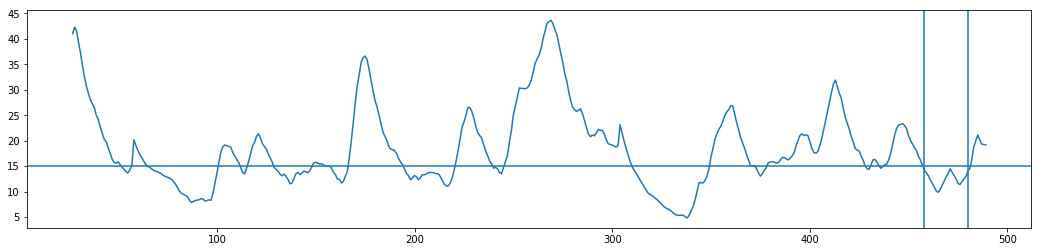

In [19]:
stock_data.ADX.plot(figsize=(18,4))
plt.axhline(15)
plt.axvline(458)
plt.axvline(480)

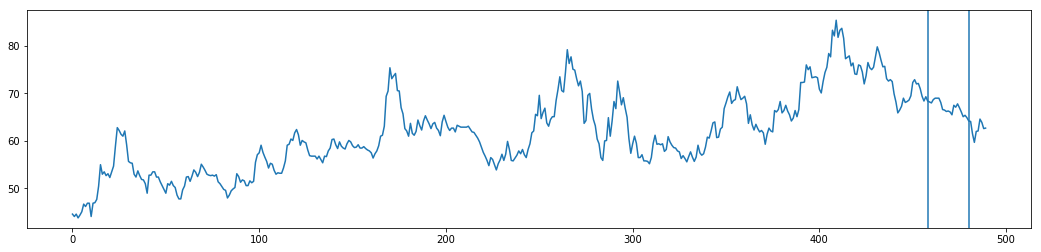

In [25]:
stock_data['close'].plot(figsize=(18,4))
plt.axvline(458)
plt.axvline(480)

In [18]:
#ADX VaLue below 20 means marker doesnt have any kind of reandyness 